# Experiment 3 : Noise and Signal on the same Channel 

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from src.numpyLSTM.MewralLSTM import MewralOldLSTM

# --- 1. Data Generator (Exp 3a: Noisy Single Wire) ---
def generate_experiment_3a_data(batch_size, T, input_size=1):
    x_seq = np.zeros((T, batch_size, input_size))
    y_seq = np.zeros((T, batch_size, input_size))
    
    for b in range(batch_size):
        # Class: +1.0 or -1.0
        is_class_positive = random.choice([True, False])
        target_val = 1.0 if is_class_positive else -1.0
        
        # t=0: The Signal
        x_seq[0, b, 0] = target_val
        
        # t=1...T: Gaussian Noise (Mean 0, Std 0.2)
        noise = np.random.normal(loc=0.0, scale=0.2, size=(T-1, input_size))
        x_seq[1:, b] = noise
        
        # Target at end
        y_seq[-1, b, 0] = target_val

    return x_seq, y_seq, T

# --- 2. Test Function (LSTM Only) ---
def test_tunnel_lstm(model, batch_size, T):
    # Generate fresh data
    X_test, y_test, _ = generate_experiment_3a_data(batch_size, T)
    
    # Forward Pass
    preds, _, _ = model.forward(X_test, retain_state=False)
    
    correct_count = 0
    for b in range(batch_size):
        last_pred = preds[-1][b, 0]
        last_target = y_test[-1, b, 0]
        
        # Check if signs match (e.g. both positive or both negative)
        if np.sign(last_pred) == np.sign(last_target):
            correct_count += 1
            
    return (correct_count / batch_size) * 100

Epoch 0: Loss = 19.8379 | Exit Accuracy: 0.0%
Epoch 20: Loss = 1.2475 | Exit Accuracy: 56.7%
Epoch 40: Loss = 0.0142 | Exit Accuracy: 100.0%


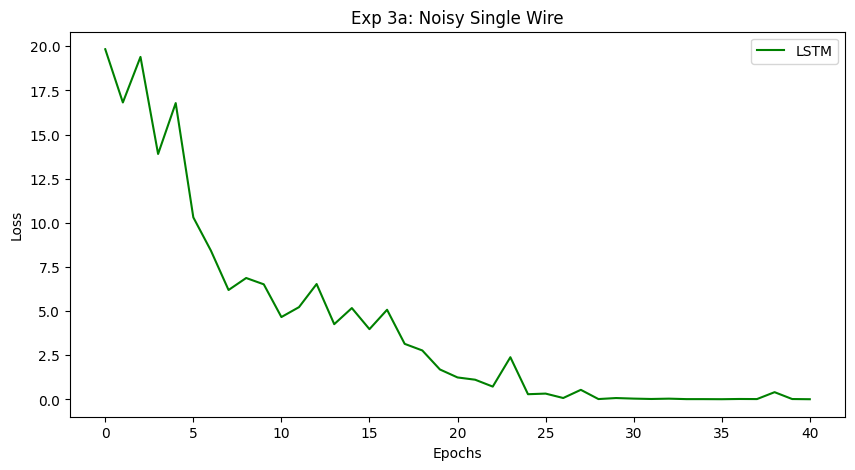

In [ ]:
from src.numpyLSTM.MewralLSTM import MewralOldLSTM


T = 100 
N = 1        
BATCH_SIZE = 30
EPOCHS = 500


INPUT_SIZE = 1
HIDDEN_SIZE = 10
LAYERS = 2
OUTPUT_SIZE = 1

LSTM = MewralOldLSTM(INPUT_SIZE, HIDDEN_SIZE, LAYERS, OUTPUT_SIZE, optimizer="sgd")
LSTM.shift_baises(-0.5,-0.5)

EPOCHS = 1000
LEARNING_RATE = 0.1

loss_history = []
for epoch in range(EPOCHS):
    X_batch, y_batch, seq_len = generate_experiment_3a_data(BATCH_SIZE, T, N)

    LSTM.last_batch_short_term_memory = None
    loss = LSTM.BPTT(X_batch, y_batch, learning_rate=LEARNING_RATE, loss_mode="last_step", retain_state=False)
    loss_history.append(loss)

    if epoch % 20 == 0:
        preds, _, _ = LSTM.forward(X_batch, retain_state=False)
        last_pred = preds[-1] 
        last_target = y_batch[-1]
        diff = np.abs(last_pred - last_target)
        correct = diff < 0.2
        accuracy = np.mean(correct) * 100
        
        print(f"Epoch {epoch}: Loss = {loss:.4f} | Exit Accuracy: {accuracy:.1f}%")
        
        if accuracy >= 99.0:
            break
x
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='LSTM', color='green')
plt.title("Exp 3a: Noisy Single Wire")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
test_accuracy = test_tunnel_lstm(LSTM, BATCH_SIZE, T)
print("----Testing on test Data----")
print(f"Test Data Accuracy: {accuracy:.1f}%")

----Testing on test Data----
Test Data Exit Accuracy: 100.0%


Starting Experiment 3a (Standard RNN)...
Epoch 0: Loss = 0.5023 | Exit Accuracy: 56.7%
Epoch 100: Loss = 0.5046 | Exit Accuracy: 50.0%
Epoch 200: Loss = 0.4990 | Exit Accuracy: 60.0%
Epoch 300: Loss = 0.5108 | Exit Accuracy: 43.3%
Epoch 400: Loss = 0.5057 | Exit Accuracy: 53.3%
Epoch 500: Loss = 0.4970 | Exit Accuracy: 60.0%
Epoch 600: Loss = 0.4791 | Exit Accuracy: 63.3%
Epoch 700: Loss = 0.5068 | Exit Accuracy: 46.7%
Epoch 800: Loss = 0.5116 | Exit Accuracy: 60.0%
Epoch 900: Loss = 0.5065 | Exit Accuracy: 46.7%


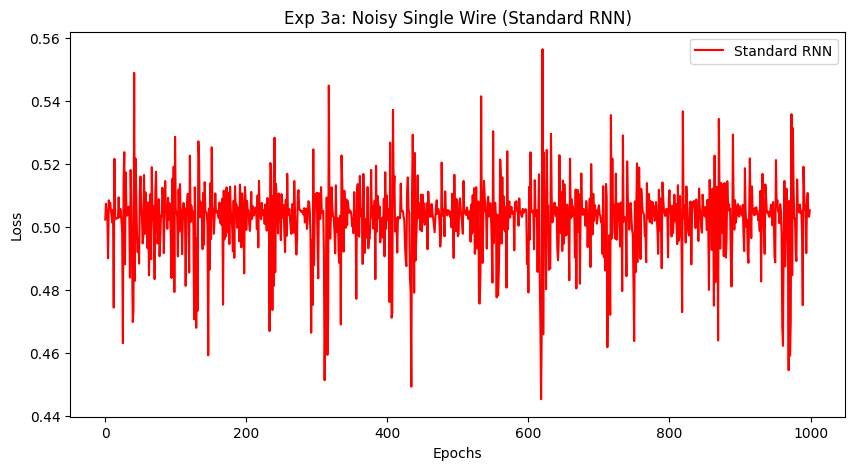

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.numpyLSTM.StandardRNN import RecurrentMewralNet

# --- Parameters ---
T = 100 
N = 1        
BATCH_SIZE = 30
INPUT_SIZE = 1
HIDDEN_SIZE = 10
LAYERS = 1 # Standard RNN usually has 1 layer logic in this scratch implementation
OUTPUT_SIZE = 1
EPOCHS = 1000
LEARNING_RATE = 0.01 # Standard RNNs are unstable; 0.1 might explode, 0.01 is safer

# --- Initialize RNN ---
# Note: Added 'initialzation' arg to match your class definition
RNN = RecurrentMewralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, initialzation="random")

loss_history = []

print("Starting Experiment 3a (Standard RNN)...")

for epoch in range(EPOCHS):
    # 1. Generate Data (Time, Batch, Features)
    X_batch, y_batch, seq_len = generate_experiment_3a_data(BATCH_SIZE, T, N)

    total_epoch_loss = 0

    # 2. Training Loop (Sample by Sample)
    for i in range(BATCH_SIZE):
        x_sample = X_batch[:, i:i+1, :]
        y_sample = y_batch[:, i:i+1, :]
        
        loss = RNN.BPTT(x_sample, y_sample, learning_rate=LEARNING_RATE, loss_mask="last_step")
        total_epoch_loss += loss

    # Average loss for the plot
    loss_history.append(total_epoch_loss / BATCH_SIZE)

    # 3. Testing Loop (Every 20 epochs)
    if epoch % 100 == 0:
        correct_count = 0
        
        for i in range(BATCH_SIZE):
            # Use the same slicing for testing
            x_sample = X_batch[:, i:i+1, :]
            y_sample = y_batch[:, i:i+1, :]
            
            # Forward pass
            preds, _ = RNN.forward(x_sample)

            last_pred = preds[-1][0, 0]
            last_target = y_sample[-1][0, 0]
            
            # Check accuracy (Sign check is more robust for +1/-1 tasks)
            if np.sign(last_pred) == np.sign(last_target):
                correct_count += 1
        
        accuracy = (correct_count / BATCH_SIZE) * 100
        
        print(f"Epoch {epoch}: Loss = {loss_history[-1]:.4f} | Exit Accuracy: {accuracy:.1f}%")
        
        if accuracy >= 99.0:
            print("Converged!")
            break

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Standard RNN', color='red')
plt.title("Exp 3a: Noisy Single Wire (Standard RNN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
def test_tunnel_rnn(model, batch_size, T):
    # Generate fresh data
    X_test, y_test, _ = generate_experiment_3a_data(batch_size, T)
    
    correct_count = 0

    for b in range(batch_size):
        # Slice to keep dimensions: (Time, 1, Input_Size)
        x_sample = X_test[:, b:b+1, :]
        
        # Forward Pass for this single sample
        preds, _ = model.forward(x_sample)
        last_pred = preds[-1][0, 0]
        last_target = y_test[-1, b, 0]
        
        # Check if signs match
        if np.sign(last_pred) == np.sign(last_target):
            correct_count += 1
            
    return (correct_count / batch_size) * 100

test_accuracy = test_tunnel_rnn(RNN, BATCH_SIZE, T)
print("----Testing on test Data----")
print(f"Test Data Accuracy: {accuracy:.1f}%")

----Testing on test Data----
Test Data Accuracy: 46.7%


In [12]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

def generate_experiment_3b_data(batch_size, T, N=1):
    # 1. Random Sequence Length
    max_len_limit = int(T + T/10)
    seq_len = np.random.randint(T, max_len_limit + 1)

    # 2. Shape is (Time, Batch, 2) for Two Wires
    X = np.zeros((seq_len, batch_size, 2))
    y = np.zeros((seq_len, batch_size, 1))
    
    classes = np.random.randint(0, 2, size=batch_size)
    noise_std = np.sqrt(0.2)
    
    for b in range(batch_size):
        # --- WIRE 1: Signal (Channel 0) ---
        # Signal for N steps, then SILENCE (0.0)
        signal_val = 1.0 if classes[b] == 1 else -1.0
        X[:N, b, 0] = signal_val
        # --- WIRE 2: Distractor (Channel 1) ---
        # Constant noise for the ENTIRE sequence
        noise = np.random.normal(loc=0.0, scale=noise_std, size=(seq_len,))
        X[:, b, 1] = noise

        # --- Target ---
        target_val = 1.0 if classes[b] == 1 else 0.0
        y[-1, b, 0] = target_val
        
    return X, y, seq_len

def test_tunnel_lstm(model, batch_size, T):
    # Generate fresh data
    X_test, y_test, _ = generate_experiment_3b_data(batch_size, T)
    
    # Forward Pass
    preds, _, _ = model.forward(X_test, retain_state=False)
    
    correct_count = 0
    for b in range(batch_size):
        last_pred = preds[-1][b, 0]
        last_target = y_test[-1, b, 0]
        
        # Check if signs match (e.g. both positive or both negative)
        if np.sign(last_pred) == np.sign(last_target):
            correct_count += 1
            
    return (correct_count / batch_size) * 100

def test_tunnel_rnn(model, batch_size, T):
    # Generate fresh data
    X_test, y_test, _ = generate_experiment_3b_data(batch_size, T)
    
    correct_count = 0

    for b in range(batch_size):
        # Slice to keep dimensions: (Time, 1, Input_Size)
        x_sample = X_test[:, b:b+1, :]
        
        # Forward Pass for this single sample
        preds, _ = model.forward(x_sample)
        last_pred = preds[-1][0, 0]
        last_target = y_test[-1, b, 0]
        
        # Check if signs match
        if np.sign(last_pred) == np.sign(last_target):
            correct_count += 1
            
    return (correct_count / batch_size) * 100

Epoch 0: Loss = 3.2853 | Exit Accuracy: 80.0%
Epoch 20: Loss = 1.8543 | Exit Accuracy: 83.3%
Epoch 40: Loss = 2.0561 | Exit Accuracy: 50.0%
Epoch 60: Loss = 1.9438 | Exit Accuracy: 96.7%
Epoch 80: Loss = 0.9771 | Exit Accuracy: 90.0%
Epoch 100: Loss = 0.0105 | Exit Accuracy: 100.0%


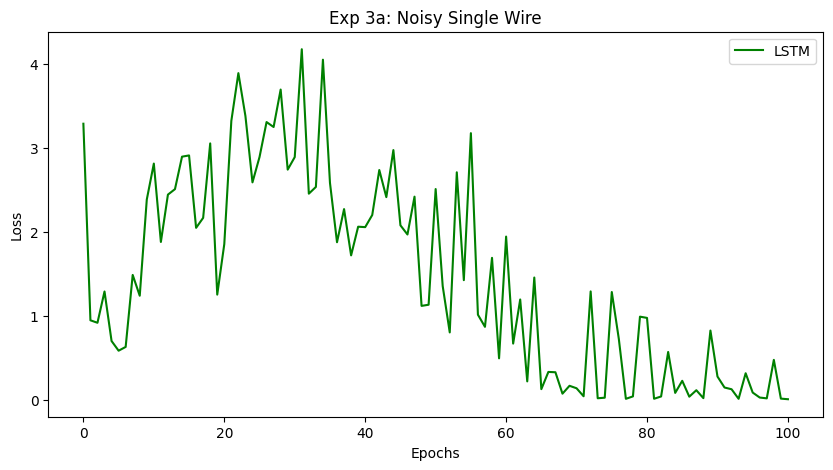

In [ ]:
from src.numpyLSTM.MewralLSTM import MewralOldLSTM


T = 100 
N = 1        
BATCH_SIZE = 30
EPOCHS = 500


INPUT_SIZE = 2
HIDDEN_SIZE = 10
LAYERS = 2
OUTPUT_SIZE = 1

LSTM = MewralOldLSTM(INPUT_SIZE, HIDDEN_SIZE, LAYERS, OUTPUT_SIZE, optimizer="sgd")
LSTM.shift_baises(-0.5,-0.5)

EPOCHS = 1000
LEARNING_RATE = 0.1

loss_history = []
for epoch in range(EPOCHS):
    X_batch, y_batch, seq_len = generate_experiment_3b_data(BATCH_SIZE, T, N)

    LSTM.last_batch_short_term_memory = None
    loss = LSTM.BPTT(X_batch, y_batch, learning_rate=LEARNING_RATE, loss_mode="last_step", retain_state=False)
    loss_history.append(loss)

    if epoch % 20 == 0:
        preds, _, _ = LSTM.forward(X_batch, retain_state=False)
        last_pred = preds[-1] 
        last_target = y_batch[-1]
        diff = np.abs(last_pred - last_target)
        correct = diff < 0.2
        accuracy = np.mean(correct) * 100
        
        print(f"Epoch {epoch}: Loss = {loss:.4f} | Exit Accuracy: {accuracy:.1f}%")
        
        if accuracy >= 99.0:
            break

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='LSTM', color='green')
plt.title("Exp 3a: Noisy Single Wire")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
test_accuracy = test_tunnel_lstm(LSTM, BATCH_SIZE, T)
print("----Testing on test Data----")
print(f"Test Data Accuracy: {accuracy:.1f}%")

----Testing on test Data----
Test Data Accuracy: 100.0%


Starting Experiment 3a (Standard RNN)...
Epoch 0: Loss = 0.2683 | Exit Accuracy: 63.3%
Epoch 100: Loss = 0.1198 | Exit Accuracy: 63.3%
Epoch 200: Loss = 0.1248 | Exit Accuracy: 56.7%
Epoch 300: Loss = 0.1195 | Exit Accuracy: 70.0%
Epoch 400: Loss = 0.1272 | Exit Accuracy: 63.3%
Epoch 500: Loss = 0.1246 | Exit Accuracy: 43.3%
Epoch 600: Loss = 0.1268 | Exit Accuracy: 53.3%
Epoch 700: Loss = 0.1211 | Exit Accuracy: 36.7%
Epoch 800: Loss = 0.1261 | Exit Accuracy: 36.7%
Epoch 900: Loss = 0.1256 | Exit Accuracy: 60.0%


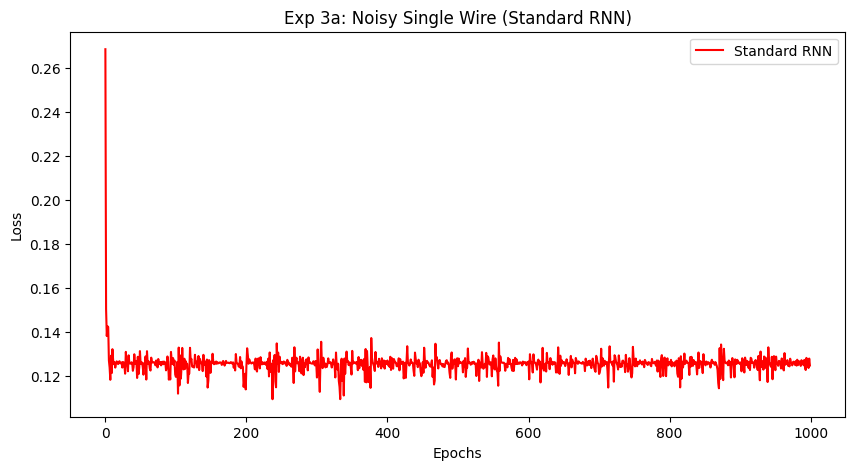

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.numpyLSTM.StandardRNN import RecurrentMewralNet

# --- Parameters ---
T = 100 
N = 1        
BATCH_SIZE = 30
INPUT_SIZE = 2
HIDDEN_SIZE = 10
LAYERS = 1 
OUTPUT_SIZE = 1
EPOCHS = 1000
LEARNING_RATE = 0.01 

RNN = RecurrentMewralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, initialzation="random")

loss_history = []

print("Starting Experiment 3a (Standard RNN)...")

for epoch in range(EPOCHS):
    # 1. Generate Data (Time, Batch, Features)
    X_batch, y_batch, seq_len = generate_experiment_3b_data(BATCH_SIZE, T, N)

    total_epoch_loss = 0

    # 2. Training Loop (Sample by Sample)
    for i in range(BATCH_SIZE):
        x_sample = X_batch[:, i:i+1, :]
        y_sample = y_batch[:, i:i+1, :]
        
        loss = RNN.BPTT(x_sample, y_sample, learning_rate=LEARNING_RATE, loss_mask="last_step")
        total_epoch_loss += loss

    # Average loss for the plot
    loss_history.append(total_epoch_loss / BATCH_SIZE)

    # 3. Testing Loop (Every 20 epochs)
    if epoch % 100 == 0:
        correct_count = 0
        
        for i in range(BATCH_SIZE):
            # Use the same slicing for testing
            x_sample = X_batch[:, i:i+1, :]
            y_sample = y_batch[:, i:i+1, :]
            
            # Forward pass
            preds, _ = RNN.forward(x_sample)

            last_pred = preds[-1][0, 0]
            last_target = y_sample[-1][0, 0]
            
            # Check accuracy (Sign check is more robust for +1/-1 tasks)
            if np.sign(last_pred) == np.sign(last_target):
                correct_count += 1
        
        accuracy = (correct_count / BATCH_SIZE) * 100
        
        print(f"Epoch {epoch}: Loss = {loss_history[-1]:.4f} | Exit Accuracy: {accuracy:.1f}%")
        
        if accuracy >= 99.0:
            print("Converged!")
            break

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Standard RNN', color='red')
plt.title("Exp 3a: Noisy Single Wire (Standard RNN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
test_accuracy = test_tunnel_rnn(RNN, BATCH_SIZE, T)
print("----Testing on test Data----")
print(f"Test Data Accuracy: {accuracy:.1f}%")

----Testing on test Data----
Test Data Accuracy: 53.3%


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from src.numpyLSTM.MewralLSTM import MewralOldLSTM
from src.numpyLSTM.StandardRNN import RecurrentMewralNet

# --- 1. Data Generator (Exp 3c: Noisy Targets) ---
def generate_experiment_3c_data(batch_size, T, input_size=1, training=True):
    """
    Inputs: Same as 3a (Signal start, Noise middle).
    Targets: 0.2 (Class 1) or 0.8 (Class 2).
    Training Twist: Targets have added Gaussian noise (SD 0.32).
    """
    x_seq = np.zeros((T, batch_size, input_size))
    y_seq = np.zeros((T, batch_size, input_size))
    
    # Clean targets for verification
    y_clean = np.zeros((batch_size, 1)) 
    
    for b in range(batch_size):
        # Class 1 (0.2) or Class 2 (0.8)
        is_class_2 = random.choice([True, False])
        
        # --- INPUTS (Same as 3a) ---
        # Signal at t=0 (+1 for Class 2, -1 for Class 1)
        signal_val = 1.0 if is_class_2 else -1.0
        x_seq[0, b, 0] = signal_val
        
        # Noise at t=1...T (Input Noise)
        input_noise = np.random.normal(loc=0.0, scale=0.2, size=(T-1, input_size))
        x_seq[1:, b] = input_noise
        
        # --- TARGETS (The Twist) ---
        base_target = 0.8 if is_class_2 else 0.2
        y_clean[b, 0] = base_target
        
        if training:
            # Add Gaussian Noise to the TARGET (Mean 0, Variance 0.1 -> SD ~0.32)
            target_noise = np.random.normal(loc=0.0, scale=0.32)
            noisy_target = base_target + target_noise
            y_seq[-1, b, 0] = noisy_target
        else:
            # For testing, we want to measure against the TRUE mean
            y_seq[-1, b, 0] = base_target

    return x_seq, y_seq, y_clean

In [19]:
def test_tunnel_3c(model, batch_size, T):
    # Generate TESTING data (No noise on targets)
    X_test, y_test, y_clean = generate_experiment_3c_data(batch_size, T, training=False)
    
    # Forward Pass
    preds, _, _ = model.forward(X_test, retain_state=False)
    
    # Get last step predictions
    last_preds = preds[-1] # Shape (Batch, 1)
    
    # --- Criteria 1: Misclassification ---
    # "Difference > 0.1" counts as an error
    abs_diffs = np.abs(last_preds - y_clean)
    num_misclassified = np.sum(abs_diffs > 0.1)
    classification_acc = (1 - (num_misclassified / batch_size)) * 100
    
    # --- Criteria 2: Precision (The Real Test) ---
    # "Mean absolute difference < 0.015"
    mae = np.mean(abs_diffs)
    
    return classification_acc, mae

--- STARTING EXPERIMENT 3c (Precision) ---
Target: MAE < 0.015
Ep 0: Loss=3.4224 | Class Acc=53% | MAE=0.2447
Ep 20: Loss=1.4617 | Class Acc=73% | MAE=0.0822
Ep 40: Loss=1.1442 | Class Acc=100% | MAE=0.0168
Ep 60: Loss=1.5975 | Class Acc=100% | MAE=0.0412
Ep 80: Loss=1.0068 | Class Acc=100% | MAE=0.0453
Ep 100: Loss=2.2234 | Class Acc=67% | MAE=0.0557
Ep 120: Loss=1.8927 | Class Acc=100% | MAE=0.0299
Ep 140: Loss=2.0753 | Class Acc=100% | MAE=0.0305
Ep 160: Loss=1.8218 | Class Acc=87% | MAE=0.0336
Ep 180: Loss=1.4819 | Class Acc=100% | MAE=0.0549
Ep 200: Loss=2.1375 | Class Acc=43% | MAE=0.0966
Ep 220: Loss=1.0573 | Class Acc=100% | MAE=0.0319
Ep 240: Loss=1.4262 | Class Acc=53% | MAE=0.0780
Ep 260: Loss=1.4916 | Class Acc=100% | MAE=0.0253
Ep 280: Loss=2.4075 | Class Acc=100% | MAE=0.0347
Ep 300: Loss=1.4143 | Class Acc=100% | MAE=0.0166
Ep 320: Loss=0.9419 | Class Acc=100% | MAE=0.0210
Ep 340: Loss=2.1095 | Class Acc=67% | MAE=0.0629
Ep 360: Loss=1.2293 | Class Acc=100% | MAE=0.0499


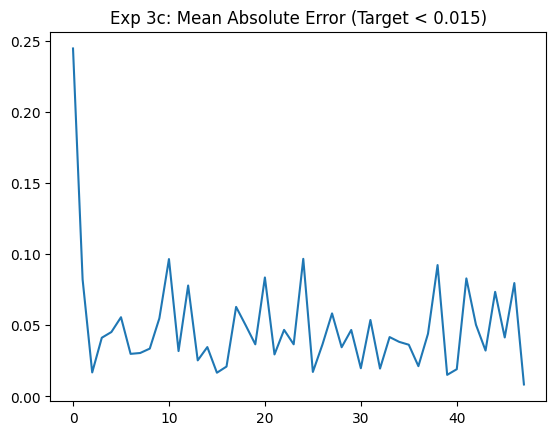

In [22]:
T = 100 
BATCH_SIZE = 30
INPUT_SIZE = 1
HIDDEN_SIZE = 10
LAYERS = 2
OUTPUT_SIZE = 1

LSTM = MewralOldLSTM(INPUT_SIZE, HIDDEN_SIZE, LAYERS, OUTPUT_SIZE, optimizer="sgd")
LSTM.shift_baises(-0.5, -0.5)

EPOCHS = 2000 # Might need more time for precision
LEARNING_RATE = 0.1

print(f"--- STARTING EXPERIMENT 3c (Precision) ---")
print("Target: MAE < 0.015")

loss_history = []
mae_history = []

for epoch in range(EPOCHS):
    # Train on NOISY targets
    X_batch, y_batch, _ = generate_experiment_3c_data(BATCH_SIZE, T, training=True)
    
    LSTM.last_batch_short_term_memory = None
    loss = LSTM.BPTT(X_batch, y_batch, learning_rate=LEARNING_RATE, loss_mode= "last_step", retain_state=False)
    loss_history.append(loss)

    if epoch % 20 == 0:
        # Test on CLEAN targets
        cls_acc, mae = test_tunnel_3c(LSTM, BATCH_SIZE, T)
        mae_history.append(mae)
        
        print(f"Ep {epoch}: Loss={loss:.4f} | Class Acc={cls_acc:.0f}% | MAE={mae:.4f}")
        
        # Stop only if we hit the high precision goal
        if mae < 0.015:
            print(f"Converged! Precision {mae:.4f} < 0.015")
            break

plt.plot(mae_history)
plt.title("Exp 3c: Mean Absolute Error (Target < 0.015)")
plt.show()